In [ ]:
import os
print(f"IMAGE_VERSION: {os.environ.get('IMAGE_VERSION', 'Not set')}")
print(f"SAGEMAKER_INTERNAL_IMAGE_URI: {os.environ.get('SAGEMAKER_INTERNAL_IMAGE_URI', 'Not set')}")

In [ ]:
from datetime import datetime
print(f"Execution Start Time (UTC): {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")


In [ ]:
# Package upgrade skipped - using environment default
print('Using default sagemaker_studio package from environment')


# Test 12: Classification Example using MLFlow

This notebook is used to illustated and end to end classification example using SageMaker MLFlow

**Goals**
- Load and explore data
- Feature engineering & preprocessing
- Train baseline model(s)
- Run hyperparameter tuning
- Log experiments, metrics, params, artifacts, and models to MLflow
- Visualize results (confusion matrix, ROC, PR, feature importance)
- Load a model from MLflow and run inference

**Requirements**
- Packages: `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `mlflow`, `joblib`

In [0]:
import os
import mlflow
import mlflow.sklearn

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

2025-11-02 23:28:31,083 - matplotlib.font_manager - INFO - generated new fontManager


## Configure MLflow tracking
We will be using the MLFlow tracking server that is available as a connection in the project.

In [0]:
from sagemaker_studio import Project
project = Project()
tracking_server_uri = project.connection('mlflow-server').data.tracking_server_arn
mlflow.set_tracking_uri(tracking_server_uri)
print("MLflow tracking URI:", mlflow.get_tracking_uri())

MLflow tracking URI: arn:aws:sagemaker:us-west-2:975050192809:mlflow-tracking-server/thunder-mlflow-test


## Load dataset and quick EDA
We'll use scikit-learn's breast cancer dataset (binary classification).

In [0]:
bc = load_breast_cancer(as_frame=True)
X = bc.frame.drop(columns=["target"])
y = bc.frame["target"]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))
feature_names = X.columns.tolist()

Features shape: (569, 30)
Target distribution:
 target
1    0.627417
0    0.372583
Name: proportion, dtype: float64


### Quick visual checks
- Pairwise plots or feature distributions
- Correlations

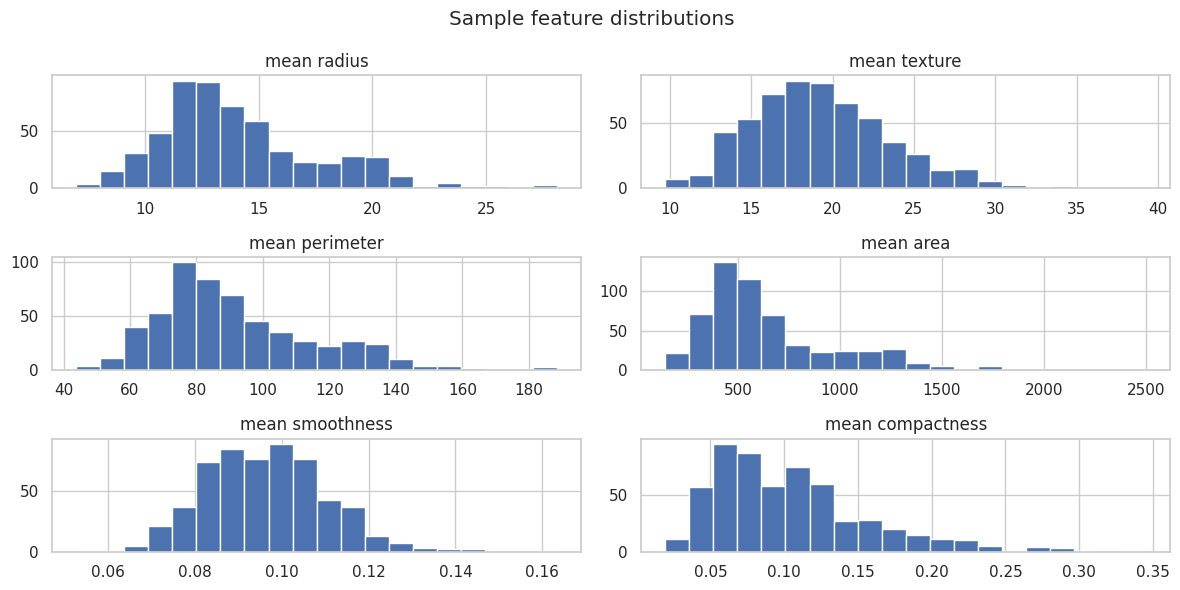

In [0]:
# Cell 4 — Correlation heatmap + a few distributions
plt.figure(figsize=(12, 8))
corr = X.corr()
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("Feature correlation matrix")
plt.tight_layout()
plt.show()

# Show distributions of a few representative features
sample_features = feature_names[:6]
X[sample_features].hist(figsize=(12, 6), bins=20)
plt.suptitle("Sample feature distributions")
plt.tight_layout()
plt.show()

## Train / test split
Use stratified split to keep class balance.

In [0]:
# Cell 5 — Train-test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (455, 30) Test shape: (114, 30)


## Baseline: Logistic Regression pipeline
We'll create a pipeline with scaling and logistic regression, evaluate, and log to MLflow.

In [0]:
# Cell 6 — Baseline pipeline and evaluation (manual logging)
baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
])

baseline_pipe.fit(X_train, y_train)
y_pred = baseline_pipe.predict(X_test)
y_proba = baseline_pipe.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}
print("Baseline metrics:", metrics)

# Log baseline into mlflow manually
with mlflow.start_run(run_name="baseline_logreg"):
    mlflow.log_params({"model": "logistic_regression", "max_iter": 2000})
    mlflow.log_metrics(metrics)
    # Log classifier as an artifact/model
    mlflow.sklearn.log_model(baseline_pipe, "model")
    # Save and log a small artifact (feature list)
    features_path = "features_baseline.txt"
    with open(features_path, "w") as f:
        f.write("\n".join(feature_names))
    mlflow.log_artifact(features_path)
    print("Baseline run logged under run id:", mlflow.active_run().info.run_id)

Baseline metrics: {'accuracy': 0.9824561403508771, 'precision': 0.9861111111111112, 'recall': 0.9861111111111112, 'f1': 0.9861111111111112, 'roc_auc': 0.9953703703703703}


2025/11/02 23:32:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/02 23:32:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2025/11/02 23:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Baseline run logged under run id: 126438b3bfca46cab0cd16bc13f52c6c
🏃 View run baseline_logreg at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/126438b3bfca46cab0cd16bc13f52c6c
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0


## Autologging + RandomForest: experiments and hyperparameter search
MLflow autologging will record parameters, metrics, artifacts, and the model automatically for scikit-learn.
We will:
- enable mlflow.sklearn.autolog()
- run RandomizedSearchCV
- log best model

In [0]:
# Cell 7 — Autologging and RandomizedSearchCV
mlflow.sklearn.autolog()  # enable autologging for sklearn

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

param_dist = {
    "n_estimators": [50, 100, 200, 400],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=RANDOM_STATE,
    verbose=1,
)

# We'll wrap training in an MLflow run so autologging ties to this run
with mlflow.start_run(run_name="rf_random_search"):
    search.fit(X_train, y_train)
    best_rf = search.best_estimator_
    print("Best params:", search.best_params_)
    print("Best CV score (roc_auc):", search.best_score_)

    # Evaluate on test set
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
    test_metrics_rf = {
        "accuracy": accuracy_score(y_test, y_pred_rf),
        "precision": precision_score(y_test, y_pred_rf),
        "recall": recall_score(y_test, y_pred_rf),
        "f1": f1_score(y_test, y_pred_rf),
        "roc_auc": roc_auc_score(y_test, y_proba_rf),
    }
    print("Test metrics for best RF:", test_metrics_rf)
    # Note: autolog already recorded parameters and metrics. We can still log custom metrics.
    mlflow.log_metrics({f"test_{k}": v for k, v in test_metrics_rf.items()})
    best_run_id = mlflow.active_run().info.run_id
    print("RF run logged under run id:", best_run_id)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025/11/02 23:33:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2025/11/02 23:33:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2025/11/02 23:33:45 INFO mlflow.sklearn.utils: Logging the 5 best runs, 15 runs will be omitted.


🏃 View run popular-bat-735 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/a28c5136830c4b70817377010e46a51d
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0
🏃 View run selective-hawk-324 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/20f4a29330a945efae67a985496a0aea
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0
🏃 View run colorful-chimp-122 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/c18c33aa969944febaa2c39863250113
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0
🏃 View run rare-frog-211 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/124c6885a5024fe1965ebfd88a8596ab
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0


🏃 View run overjoyed-moose-621 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/6edf81891a3d4fc78599a4b4099a9a59
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0
Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
Best CV score (roc_auc): 0.9901960784313726


Test metrics for best RF: {'accuracy': 0.956140350877193, 'precision': 0.958904109589041, 'recall': 0.9722222222222222, 'f1': 0.9655172413793104, 'roc_auc': 0.9933862433862434}
RF run logged under run id: a258bf7ab3de405daf81b18cdb3ca3a5
🏃 View run rf_random_search at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/a258bf7ab3de405daf81b18cdb3ca3a5
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0


## Visualize results (confusion matrix, ROC, PR)

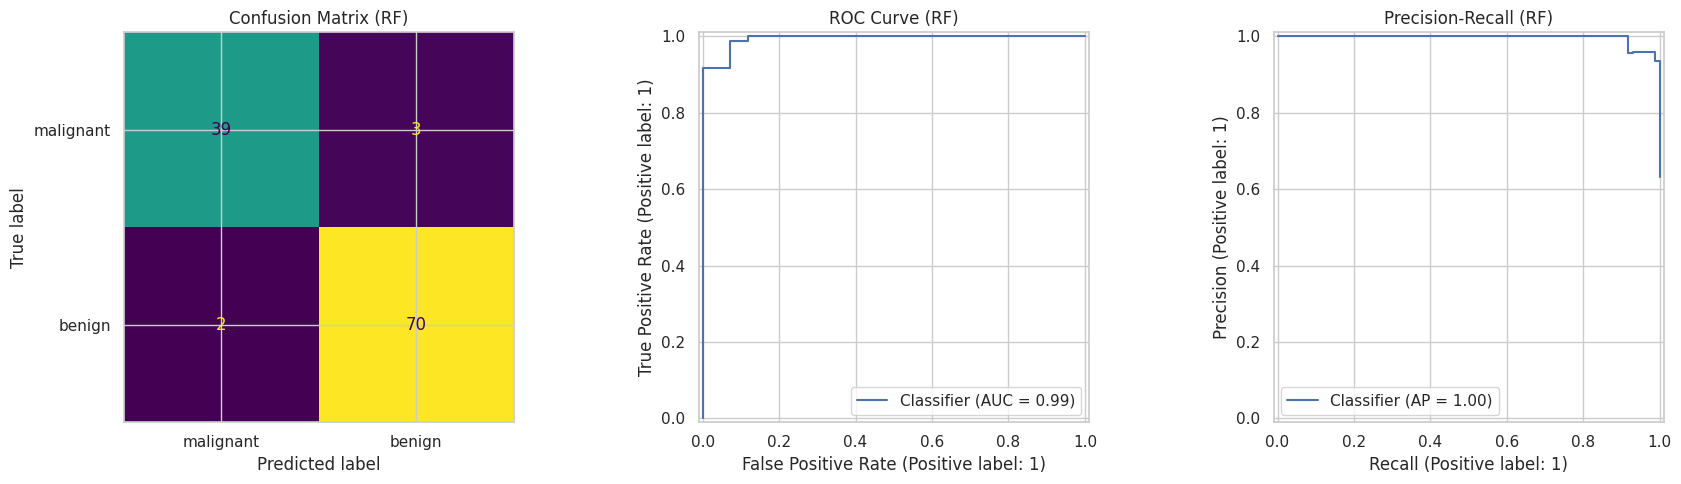

In [0]:
# Cell 8 — Plots: confusion matrix, ROC, PR curve
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bc.target_names)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix (RF)")

# ROC
RocCurveDisplay.from_predictions(y_test, y_proba_rf, ax=axes[1])
axes[1].set_title("ROC Curve (RF)")

# Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf, ax=axes[2])
axes[2].set_title("Precision-Recall (RF)")

plt.tight_layout()
plt.show()

## Feature importance (Random Forest)
Show top features using feature importances.

Top features:
 worst perimeter         0.140638
worst area              0.131204
worst concave points    0.109049
worst radius            0.108912
mean concave points     0.078846
mean area               0.060565
mean radius             0.055485
mean perimeter          0.052240
mean concavity          0.036448
worst concavity         0.032472
dtype: float64


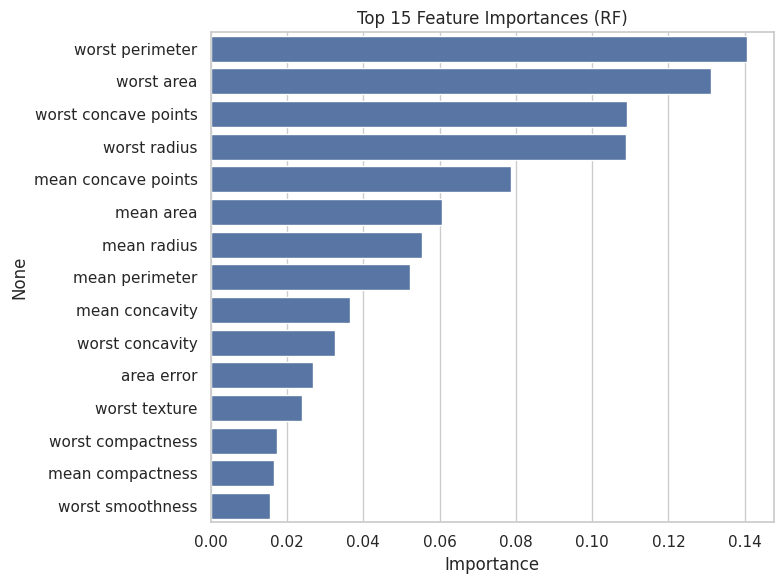

In [0]:
# Cell 9 — Feature importances
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top features:\n", feat_imp.head(10))

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index)
plt.title("Top 15 Feature Importances (RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Save the pipeline + best model to MLflow
We typically combine preprocessing + model into a single pipeline for serving.

In [0]:
# Cell 10 — Save final pipeline to MLflow (fixed)
from sklearn.pipeline import make_pipeline

final_pipeline = make_pipeline(StandardScaler(), best_rf)

# Fit the new pipeline on the training data
final_pipeline.fit(X_train, y_train)

with mlflow.start_run(run_name="rf_final_pipeline"):
    # Log identifying parameters
    mlflow.log_params({
        "final_model": "random_forest_pipeline",
        "random_state": RANDOM_STATE
    })

    # Log model to MLflow
    mlflow.sklearn.log_model(final_pipeline, artifact_path="model")

    # Evaluate and log test metrics
    y_pred_final = final_pipeline.predict(X_test)
    y_proba_final = final_pipeline.predict_proba(X_test)[:, 1]
    final_metrics = {
        "accuracy": accuracy_score(y_test, y_pred_final),
        "precision": precision_score(y_test, y_pred_final),
        "recall": recall_score(y_test, y_pred_final),
        "f1": f1_score(y_test, y_pred_final),
        "roc_auc": roc_auc_score(y_test, y_proba_final),
    }
    mlflow.log_metrics({f"test_{k}": v for k, v in final_metrics.items()})

    print("✅ Final pipeline fitted and logged successfully.")
    print("Run ID:", mlflow.active_run().info.run_id)
    print("Final test metrics:", final_metrics)

2025/11/02 23:36:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1446ebee23eb47ba9e4bcc03ca897e27', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/11/02 23:36:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2025/11/02 23:36:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run fun-kit-301 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/1446ebee23eb47ba9e4bcc03ca897e27
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0


2025/11/02 23:36:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2025/11/02 23:36:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Final pipeline fitted and logged successfully.
Run ID: c19d824ddc3b4c29b8f771685e7abb45
Final test metrics: {'accuracy': 0.956140350877193, 'precision': 0.958904109589041, 'recall': 0.9722222222222222, 'f1': 0.9655172413793104, 'roc_auc': 0.9933862433862434}
🏃 View run rf_final_pipeline at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0/runs/c19d824ddc3b4c29b8f771685e7abb45
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/0


## Load a saved model from MLflow and make predictions
Find the run containing the saved `model` artifact and load it for inference.


In [0]:
# Cell 11 — Load model from MLflow and predict (fixed)
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri=mlflow.get_tracking_uri())

def find_latest_run_by_name(run_name: str):
    """Find the most recent run by its MLflow run name."""
    try:
        # MLflow 2.x way — use search_runs
        experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
    except Exception:
        # Fallback for older MLflow versions
        experiments = [exp.experiment_id for exp in client.list_experiments()]

    for exp_id in experiments:
        runs = client.search_runs(
            [exp_id],
            filter_string=f"tags.mlflow.runName = '{run_name}'",
            order_by=["attributes.start_time DESC"],
            max_results=1,
        )
        if runs:
            return runs[0]
    return None


# --- Load model and predict ---
run_info = find_latest_run_by_name("rf_final_pipeline")

if run_info:
    run_id = run_info.info.run_id
    model_uri = f"runs:/{run_id}/model"
    print(f"Loading model from: {model_uri}")
    loaded_model = mlflow.sklearn.load_model(model_uri)

    # Test predictions
    sample_X = X_test.iloc[:5]
    preds = loaded_model.predict(sample_X)
    preds_proba = loaded_model.predict_proba(sample_X)[:, 1]
    print("Predictions:", preds)
    print("Probabilities:", preds_proba)
else:
    print("No run found with that name. You can check run names via mlflow.search_runs().")

Loading model from: runs:/c19d824ddc3b4c29b8f771685e7abb45/model


/sagemaker_packages/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predictions: [0 1 0 0 0]
Probabilities: [0.         1.         0.14833333 0.18416667 0.00125   ]
